# North Atlantic O2 (updated)
    - This script shows a workflow of estimating absolute O2 using ESM output and a few ML regressors
    - O2 is estimated as a function of T, S, Stratification, long, lat, time
    - Estimation methods include Multiple Linear Regression, Support Vector Machine, and Neural Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import sklearn as skl
import gsw
from scipy.interpolate import interp1d

### First prepare O2, T, S, stratification data

In [2]:
# access model output
model = 'GFDL-ESM4'
dir = '/glade/work/ito/dataset/model/'+model+'/'
dira= '/glade/work/acervania/dataset/model/'+model+'/'
ds0=xr.open_dataset(dir+'o2_'+model+'_196501-201412_subsampled.nc')
ds1=xr.open_dataset(dir+'so_'+model+'_196501-201412_subsampled.nc')
ds2=xr.open_dataset(dir+'thetao_'+model+'_196501-201412_subsampled.nc')
ds3=xr.open_dataset(dira+'Nsquared_MLD_'+model+'_196501-201412_subsampled.nc')

In [3]:
# basin mask
dsm=xr.open_dataset('/glade/work/ito/dataset/model/basin_mask_01.nc')
# observation coordinates
dsd=xr.open_dataset('/glade/work/ito/dataset/model/mask_woagrid_196501-201412.nc')

In [4]:
# get coordinates
x=ds0.lon.to_numpy()
y=ds0.lat.to_numpy()
xi=np.arange(0,360,1)
yi=np.arange(0,180,1)
xx,yy=np.meshgrid(x,y)
xxi,yyi=np.meshgrid(xi,yi)
z=ds0.depth.to_numpy()

In [5]:
ma = dsm.basin_mask.to_numpy()
z_ma = dsm.depth.to_numpy()
z=ds0.depth.to_numpy()
Ntr=[19,180,360]
ma1=np.zeros((Ntr))
for i in range(360):
    for j in range(180):
        maint=interp1d(z_ma,ma[:,j,i],kind='nearest')
        ma1[:,j,i]=maint(z)

In [6]:
def get_data(basin,zind,ma3d):
    # get coordinates
    x=ds0.lon.to_numpy()
    y=ds0.lat.to_numpy()
    xx,yy=np.meshgrid(x,y)
    z=ds0.depth.to_numpy()
    ma=np.squeeze(ma3d[zind,:,:])
    #
    # extract data in the Atlantic basin
    o2 = ds0.o2.isel(depth=zind).to_numpy()*1e3
    so = ds1.so.isel(depth=zind).to_numpy()
    to = ds2.thetao.isel(depth=zind).to_numpy()
    dr = ds3.Nsquared.isel(depth=zind).to_numpy()
    mld= ds3.MLD.isel(depth=zind).to_numpy()
    N3d=np.shape(o2)
    #
    xx1 = np.tile(xx,[N3d[0],1,1])
    yy1 = np.tile(yy,[N3d[0],1,1])
    #
    it=np.empty((N3d[0],1,1))
    it[:,0,0]=np.arange(0,N3d[0],1)
    tt0 = np.tile(it,[1,N3d[1],N3d[2]])
    #
    doa0=np.where((ma==basin),o2,np.nan).flatten()
    dsa0=np.where((ma==basin),so,np.nan).flatten()
    dta0=np.where((ma==basin),to,np.nan).flatten()
    dra0=np.where((ma==basin),dr,np.nan).flatten()
    dha0=np.where((ma==basin),mld,np.nan).flatten()
    #
    xx0  = xx1.flatten()
    yy0  = yy1.flatten()
    tt0  = tt0.flatten()
    #
    dd = doa0 + dsa0 + dta0 + dra0 + dha0
    doa1=doa0[np.isnan(dd)==False]
    dsa1=dsa0[np.isnan(dd)==False]
    dta1=dta0[np.isnan(dd)==False]
    dra1=dra0[np.isnan(dd)==False]
    dha1=dha0[np.isnan(dd)==False]
    xx1=xx0[np.isnan(dd)==False]
    yy1=yy0[np.isnan(dd)==False]
    t00=tt0[np.isnan(dd)==False]
    Nsample = np.size(doa1)
    print(Nsample)
    #
    #X = np.array([dsa1, dta1, dra1, dha1, xx1, yy1, t00, t01, t02])
    zz1=np.ones(Nsample)*z[zind]
    Xout = np.array([dsa1, dta1, dra1, dha1, xx1, yy1, zz1, t00])
    yout = doa1
    return Xout,yout

In [7]:
# get atlantic data : basin = 1
Xd,yd=get_data(1,0,ma1)
#
for k in np.arange(1,19,1):
    print('working on z='+str(z[k]))
    X0,y0=get_data(1,k,ma1)
    Xd=np.concatenate((Xd,X0),axis=1)
    yd=np.concatenate((yd,y0),axis=0)

0
working on z=10.0
0
working on z=20.0
53156
working on z=30.0
51898
working on z=50.0
49550
working on z=75.0
46919
working on z=100.0
44510
working on z=125.0
42962
working on z=150.0
40631
working on z=200.0
38318
working on z=250.0
36393
working on z=300.0
32780
working on z=400.0
27430
working on z=500.0
23594
working on z=600.0
18948
working on z=700.0
13067
working on z=800.0
7587
working on z=900.0
5308
working on z=1000.0
5220


### Now we have the anormaly data for the North Atlantic. Remove NaNs and organize them into 1d array
    - salinity
    - temperature
    - stratification (N2)
    - mixed layer depth
    - lon
    - lat
    - depth
    - time

In [8]:
Xm = np.mean(Xd,axis=1)
Xstd = np.std(Xd,axis=1)
#
N=np.size(yd)
# normalize x and y
Xa = (Xd.T - Xm)/Xstd
ym = np.mean(yd)
ystd = np.std(yd)
ya = (yd-ym)/ystd

## ML

### First split the data into training and test set

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xa, ya,random_state=1)

### MLR estimator (MLregr)

In [10]:
##
## Multiple Linear Regression
##
from sklearn.linear_model import LinearRegression

In [11]:
# fit model
MLregr = LinearRegression().fit(X_train, y_train)
#MLregr.coef_
#MLregr.intercept_
out=MLregr.predict(X_test)

0.42888972177568396
correlation =  0.654898565704886
RMSE =  45.89951660418321


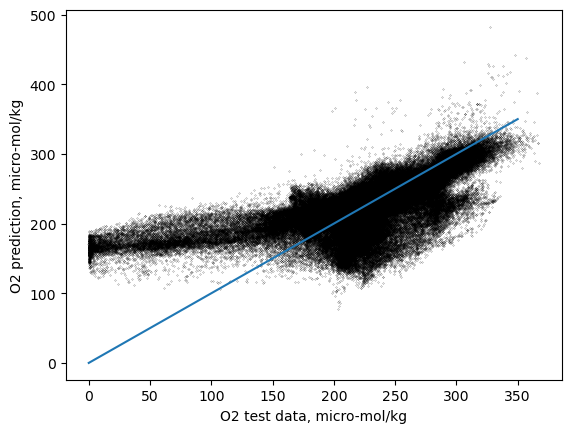

In [12]:
# test model output
score=MLregr.score(X_test, y_test)
print(score)
o2est = out*ystd + ym
o2test= y_test*ystd + ym
plt.plot(o2test,o2est,'k.',markersize=.3)
plt.plot([0,350],[0,350])
plt.ylabel('O2 prediction, micro-mol/kg')
plt.xlabel('O2 test data, micro-mol/kg')
temp=np.corrcoef(o2est,o2test)
Rval_MLR=temp[0,1]
print('correlation = ',Rval_MLR)
RMSE_MLR=np.sqrt(np.mean((o2est-o2test)**2))
print('RMSE = ',RMSE_MLR)

### Random forest regressor (RFregr)
    - from sklearn.ensemble import RandomForestRegressor

In [13]:
from sklearn.ensemble import RandomForestRegressor

In [17]:
RFregr = regr = RandomForestRegressor(random_state=0)
RFregr.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [18]:
out = RFregr.predict(X_test)
RFregr.score(X_test, y_test)

0.9942271573831262

correlation =  0.9971113143443665
RMSE =  4.6146947815903605


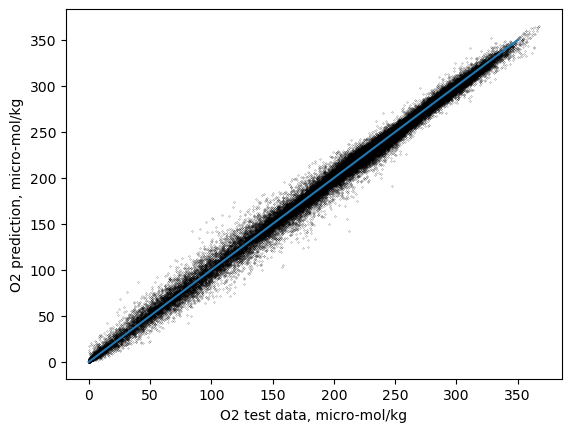

In [19]:
o2est = out*ystd + ym
o2test= y_test*ystd + ym
#
plt.plot(o2test,o2est,'k.',markersize=.3)
plt.plot([0,350],[0,350])
plt.ylabel('O2 prediction, micro-mol/kg')
plt.xlabel('O2 test data, micro-mol/kg')
temp=np.corrcoef(o2est,o2test)
Rval_RF=temp[0,1]
print('correlation = ',Rval_RF)
RMSE_RF=np.sqrt(np.mean((o2est-o2test)**2))
print('RMSE = ',RMSE_RF)

In [20]:
RFregr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

### shallow Neural Network estimator (SNNregr)

In [21]:
## NN
from sklearn.neural_network import MLPRegressor

In [22]:
# shallow NN
sNNregr = MLPRegressor(hidden_layer_sizes=(10,10),random_state=1, max_iter=500).fit(X_train, y_train)

In [23]:
out = sNNregr.predict(X_test)
sNNregr.score(X_test, y_test)

0.9552165556232342

### deep Neural Network estimator (NNregr)

In [24]:
# deep NN 30-30-30-5
NNregr = MLPRegressor(hidden_layer_sizes=(40,40,40,40),random_state=1, max_iter=500).fit(X_train, y_train)

In [25]:
out = NNregr.predict(X_test)
NNregr.score(X_test, y_test)

0.9888647484666857

correlation =  0.9944740663416248
RMSE =  6.409116095454767


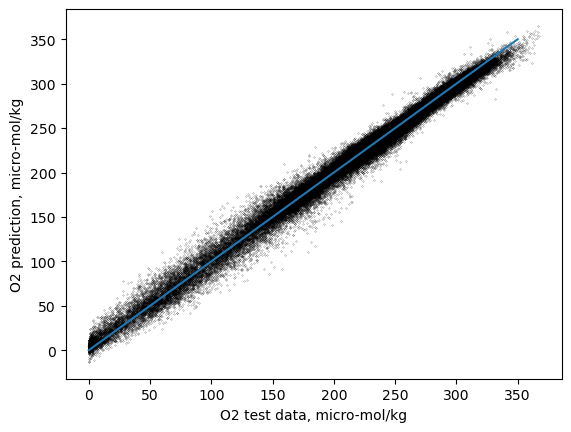

In [26]:
o2est = out*ystd + ym
o2test= y_test*ystd + ym
#
plt.plot(o2test,o2est,'k.',markersize=.3)
plt.plot([0,350],[0,350])
plt.ylabel('O2 prediction, micro-mol/kg')
plt.xlabel('O2 test data, micro-mol/kg')
temp=np.corrcoef(o2est,o2test)
Rval_NN=temp[0,1]
print('correlation = ',Rval_NN)
RMSE_NN=np.sqrt(np.mean((o2est-o2test)**2))
print('RMSE = ',RMSE_NN)

Text(0, 0.5, 'Loss function')

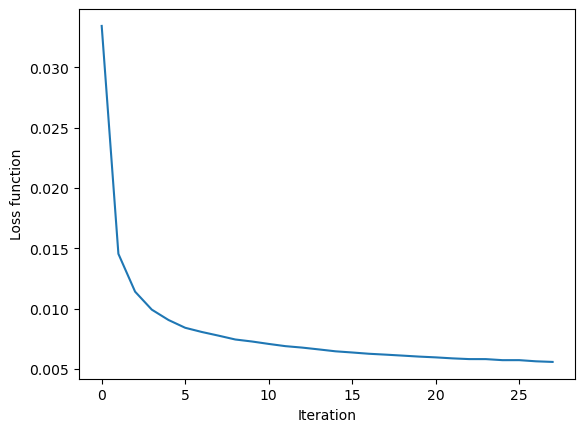

In [27]:
# plot the loss function
plt.plot(NNregr.loss_curve_)
plt.xlabel('Iteration')
plt.ylabel('Loss function')

In [28]:
NNregr.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (40, 40, 40, 40),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 500,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

## mapping O2 for a particular year and month

In [44]:
year = 2000
month = 3
it = month+(year-1965)*12-1
print('time index = '+str(it))
zlev = 200
N3d=[600,180,360]

time index = 422


In [45]:
dc0=xr.open_dataset(dir+'o2_'+model+'_196501-201412.nc')
dc1=xr.open_dataset(dir+'so_'+model+'_196501-201412.nc')
dc2=xr.open_dataset(dir+'thetao_'+model+'_196501-201412.nc')
dc3=xr.open_dataset(dira+'Nsquared_MLD_'+model+'_196501-201412.nc')
#
# prepare TS input, prepare O2 test data
soa=dc1.so.isel(time=it).sel(depth=zlev)
toa=dc2.thetao.isel(time=it).sel(depth=zlev)
o2a=dc0.o2.isel(time=it).sel(depth=zlev)*1e3
dra=dc3.Nsquared.isel(time=it).sel(depth=zlev)
dha=dc3.MLD.isel(time=it).sel(depth=zlev)
zo=dc0.depth.to_numpy()
kind=(zo==zlev)
ma=np.squeeze(ma1[kind,:,:])

In [46]:
# apply mask for the north atlantic
doa=np.where((ma==1),o2a,np.nan)
dsa=np.where((ma==1),soa,np.nan)
dta=np.where((ma==1),toa,np.nan)
dra=np.where((ma==1),dra,np.nan)
dha=np.where((ma==1),dha,np.nan)
# time data
tt0 = it*np.ones([N3d[1],N3d[2]])

In [47]:
# create data vector
doa0 = doa.flatten()
dsa0 = dsa.flatten()
dta0 = dta.flatten()
dra0 = dra.flatten()
dha0 = dha.flatten()
xx0  = xx.flatten()
yy0  = yy.flatten()
xi0  = xxi.flatten()
yi0  = yyi.flatten()
tt0  = tt0.flatten()
#

In [48]:
# remove nan
dd = dsa0 + dta0 + dra0 + doa0 + dha0
doa1=doa0[np.isnan(dd)==False]
dsa1=dsa0[np.isnan(dd)==False]
dta1=dta0[np.isnan(dd)==False]
dra1=dra0[np.isnan(dd)==False]
dha1=dha0[np.isnan(dd)==False]
xx1=xx0[np.isnan(dd)==False]
yy1=yy0[np.isnan(dd)==False]
xi1=xi0[np.isnan(dd)==False]
yi1=yi0[np.isnan(dd)==False]
t01=tt0[np.isnan(dd)==False]
z1=zlev*np.ones(np.size(t01))
Nsample = np.size(dsa1)
print(Nsample)

6523


In [49]:
# generate data matrix and standardize it
X = np.array([dsa1, dta1, dra1, dha1, xx1, yy1, z1, t01])
Xa = (X.T - Xm)/Xstd

In [50]:
# projection
out = NNregr.predict(Xa)
outMLR = MLregr.predict(Xa)
outRF = RFregr.predict(Xa)
outSNN=sNNregr.predict(Xa)

In [51]:
temp = np.nan*np.zeros((180,360))
for n in range(Nsample):
    temp[yi1[n],xi1[n]]=out[n]
o2estNN = temp*ystd + ym
RMSE_DNN=np.sqrt(np.mean((out*ystd+ym-doa1)**2))
temp=np.corrcoef(doa1,out)
R_DNN=temp[0,1]

In [52]:
temp = np.nan*np.zeros((180,360))
for n in range(Nsample):
    temp[yi1[n],xi1[n]]=outMLR[n]
o2estMLR = temp*ystd + ym
RMSE_MLR=np.sqrt(np.mean((outMLR*ystd+ym-doa1)**2))
temp=np.corrcoef(doa1,outMLR)
R_MLR=temp[0,1]

In [53]:
temp = np.nan*np.zeros((180,360))
for n in range(Nsample):
    temp[yi1[n],xi1[n]]=outRF[n]
o2estRF = temp*ystd + ym
RMSE_RF=np.sqrt(np.mean((outRF*ystd+ym-doa1)**2))
temp=np.corrcoef(doa1,outRF)
R_RF=temp[0,1]

In [54]:
temp = np.nan*np.zeros((180,360))
for n in range(Nsample):
    temp[yi1[n],xi1[n]]=outSNN[n]
o2estSNN = temp*ystd + ym
RMSE_SNN=np.sqrt(np.mean((outSNN*ystd+ym-doa1)**2))
temp=np.corrcoef(doa1,outSNN)
R_NN=temp[0,1]

Text(0.5, 1.0, 'RMSE')

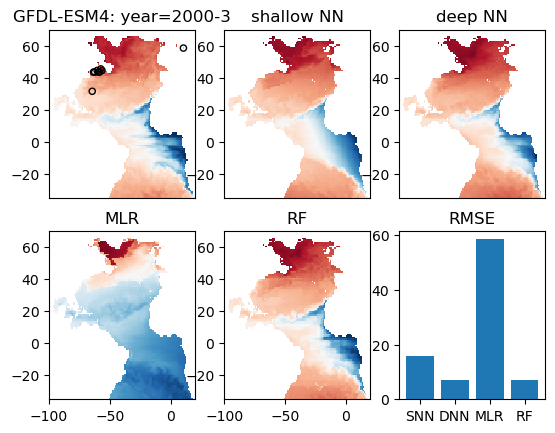

In [56]:
dat = dsd.isel(time=it).sel(depth=zlev)
fig,ax=plt.subplots(2,3)
ax[0,0].pcolormesh(xx,yy,doa,cmap='RdBu_r')
dpos=dat.mask.to_numpy()
xxx=np.where((ma==1)&(yy>0),xx,np.nan)
yyy=np.where((ma==1)&(yy>0),yy,np.nan)
xpos=xxx[dpos==1]
ypos=yyy[dpos==1]
ax[0,0].scatter(xpos, ypos, s=20, facecolors='none', edgecolors='k')
ax[0,0].set_xlim(-100,20)
ax[0,0].set_ylim(-35,70)
ax[0,0].set_title(model+': year='+str(year)+'-'+str(month))
ax[0,0].set_xticks([])
#
ax[0,1].pcolormesh(xx,yy,o2estSNN,cmap='RdBu_r')
ax[0,1].set_xlim(-100,20)
ax[0,1].set_ylim(-35,70)
ax[0,1].set_title('shallow NN')
ax[0,1].set_xticks([])
#
ax[0,2].pcolormesh(xx,yy,o2estNN,cmap='RdBu_r')
ax[0,2].set_xlim(-100,20)
ax[0,2].set_ylim(-35,70)
ax[0,2].set_title('deep NN')
ax[0,2].set_xticks([])
#
#ax[0,2].pcolormesh(xx,yy,o2est-doa,vmin=-30,vmax=30,cmap='RdBu_r')
#ax[0,2].set_xlim(-100,20)
#ax[0,2].set_ylim(-5,70)
#ax[0,2].set_title('bias')
#
ax[1,0].pcolormesh(xx,yy,o2estMLR,cmap='RdBu_r')
ax[1,0].set_xlim(-100,20)
ax[1,0].set_ylim(-35,70)
ax[1,0].set_title('MLR')
#
ax[1,1].pcolormesh(xx,yy,o2estRF,cmap='RdBu_r')
ax[1,1].set_xlim(-100,20)
ax[1,1].set_ylim(-35,70)
ax[1,1].set_title('RF')
#
#ax[1,2].bar(['NN','DNN','MLR'],[RMSE_SNN,RMSE_DNN,RMSE_MLR])
#ax[1,2].set_title('RMSE')
ax[1,2].bar(['SNN','DNN','MLR','RF'],[RMSE_SNN,RMSE_DNN,RMSE_MLR,RMSE_RF])
ax[1,2].set_title('RMSE')
#ax[1,2].bar(['NN','DNN','MLR','RF'],[R_NN**2,R_DNN**2,R_MLR**2,R_RF**2])